<a href="https://colab.research.google.com/github/aayush1036/python_for_financial_analysis/blob/main/exponential_weighted_moving_average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
airline = pd.read_csv('airline_passengers.csv', index_col='Month')

In [3]:
airline.head()

,Thousands of Passengers
Month,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


In [5]:
airline.dropna(inplace=True)

In [6]:
airline_index = pd.to_datetime(airline.index)

In [7]:
airline_index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [8]:
airline.index = airline_index

In [9]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [10]:
airline['6-month-sma'] = airline['Thousands of Passengers'].rolling(window=6).mean()

In [11]:
airline['12-month-sma'] = airline['Thousands of Passengers'].rolling(window=12).mean()

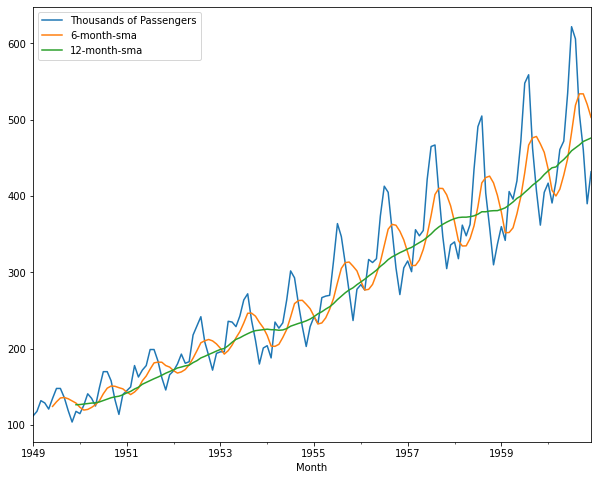

In [13]:
airline.plot(figsize=(10,8))

Weakness of sma 



1.   smaller window size leads to more noise
2.   sma lags in the starting (eg 6 month sma would start at 6 instead of 1 etc) 
3.   Never reaches the full peak of the data due to averaging 
4.   Does not inform you about the future behavior, it just describes the trends 
5.   Extremely old and irrelevant values might skew your data (eg - For example the company went through a huge loss during the 2008 financial crisis but now it has recovered the losses but still including those data points may skew your data negatively which is undesirable)



EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.
[Full details on Mathematics behind this can be found here](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows)
Here is the shorter version of the explanation behind EWMA.

The formula for EWMA is:

$ y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i} $

Where x_t is the input value, w_i is the applied weight (Note how it can change from i=0 to t), and y_t is the output.

Now the question is, how to we define the weight term w_i ?

This depends on the adjust parameter you provide to the .ewm() method.

When adjust is True (default), weighted averages are calculated using weights:

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When adjust=False is specified, moving averages are calculated as:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When adjust=True we have y0=x0 and from the last representation above we have yt=αxt+(1−α)yt−1, therefore there is an assumption that x0 is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

One must have 0<α≤1, and while since version 0.18.0 it has been possible to pass α directly, it’s often easier to think about either the span, center of mass (com) or half-life of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

* Span corresponds to what is commonly called an “N-day EW moving average”.
* Center of mass has a more physical interpretation and can be thought of in terms of span: c=(s−1)/2
* Half-life is the period of time for the exponential weight to reduce to one half.
* Alpha specifies the smoothing factor directly.

In [14]:
airline['EWMA-12'] = airline['Thousands of Passengers'].ewm(span=12).mean()

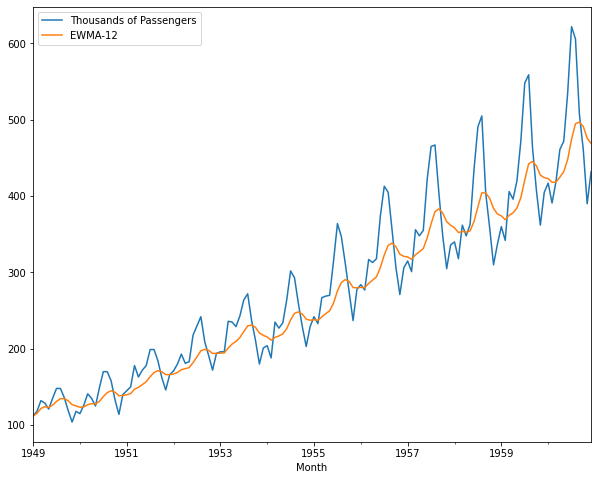

In [16]:
airline[['Thousands of Passengers', 'EWMA-12']].plot(figsize=(10,8))

In this figure we notice different behaviors at the start and at the end

The seasonality trend is more clearer at the end than in the begining which is because we have weighted the points more towards the end of the df heavier than the points at the begining of the df